# Capstone Project: Criminal Case Database

### Overall Contents:
- Background
- Data Cleaning
- [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis) **(In this notebook)**
- Modeling 1 Logistic Regression
- Modeling 2 k-Nearest Neighbours
- Modeling 3 Random Forest
- Evaluation
- Conclusion and Recommendation

### Data Dictionary

The dataset contains the weather, location, testing and spraying in the City of Chicago.The data source below are obtained from [kaggle](https://www.kaggle.com/c/predict-west-nile-virus/data).

The dataset used for this analysis are as followed:--

* train_df (2007, 2009, 2011, 2013)
* spray_df (2011 to 2013)
* weather_df (2007 to 2014)
* test_df (2008, 2010, 2012, 2014)

|Feature|Type|Dataset|Description|
|:---|:---|:---|:---|
|**date**|*object*|train_df<br>test_df|The date that the West Nile Virus test is performed|
|**species**|*object*|train_df<br>test_df|The species of mosquitos|
|**trap**|*object*|train_df<br>test_df|Id of the trap|
|**addressnumberandstreet**|*object*|train_df<br>test_df|Approximate address returned from GeoCoder|
|**latitude**|*float64*|train_df<br>test_df|Latitude returned from GeoCoder|
|**longitude**|*float64*|train_df<br>test_df|Longitude returned from GeoCoder|
|**nummosquitos**|*int64*|train_df|Number of mosquitoes caught in this trap|
|**wnvpresent**|*int64*|train_df|Whether West Nile Virus was present in these mosquitos.<br>1 means West Nile Virus is present, and 0 means not present|
|**station**|*int64*|weather_df|Weather stations<br>Station 1 is located at Chicago O'Hare International Airport<br>Station 2 is located at Chicago Midway Intl Arpt|
|**date**|*object*|weather_df|The date of the weather information is collected|
|**tmax**|*int64*|weather_df|Maximum temperature (&deg;F)|
|**tmin**|*int64*|weather_df|Minimum temperature (&deg;F)|
|**tavg**|*int32*|weather_df|Average temperature (&deg;F)|
|**dewpoint**|*int64*|weather_df|Average dew point (&deg;F)|
|**wetbulb**|*int32*|weather_df|Average wet bulb (&deg;F)|
|**heat**|*int32*|weather_df|Heating degree days (Base 65&deg;F)|
|**cool**|*int32*|weather_df|Cooling degree days (Base 65&deg;F)|
|**codesum**|*object*|weather_df|Weather phenomena for significant weather types|
|**preciptotal**|*float64*|weather_df|Total precipitation (Inches and Hundredths)|
|**stnpressure**|*float64*|weather_df|Average station pressure (Inches of Hg)|
|**sealevel**|*float64*|weather_df|Average sea level pressure (Inches of Hg)|
|**resultspeed**|*float64*|weather_df|Resultant wind speed (miles per hour)|
|**resultdir**|*int64*|weather_df|Resultant wind direction (tens of whole degrees)|
|**avgspeed**|*float64*|weather_df|Average wind speed|
|**date**|*object*|spray_df|The date of the spray|
|**latitude**|*float64*|spray_df|Latitude of the spray|
|**longitude**|*float64*|spray_df|Longitude of the spray|

## 3. Exploratory Data Analysis

### 3.1 Libraries Import

In [50]:
# Imports:
from datetime import datetime
from IPython.display import clear_output
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [51]:
pd.set_option('display.max_colwidth', 500)

### 3.2 Data Import

In [52]:
# Import database of judgments which were processed in the previous notebook.
database = pd.read_csv('../data/database.csv')

In [53]:
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 10 columns):
aggravated_discussed    122 non-null int64
case_name               122 non-null object
citations               117 non-null object
court                   122 non-null object
decision date           122 non-null object
link                    122 non-null object
mitigation_discussed    122 non-null int64
offences                83 non-null object
statutes                83 non-null object
tribunal/court          122 non-null object
dtypes: int64(2), object(8)
memory usage: 9.6+ KB


### 3.3 Search Algorithm

In [45]:
def classify_search(input_string):
    if re.search('[Aa]ct|[Cc]ode', input_string):
        try:
            section = re.search('(([Ss](ection|)(s|) |)\d+)', input_string).group(0).strip()
            section_num = re.sub('([Ss](ection|)(s|) )', "", section)
        except:
            section_num = ""
        statute = re.search(r'((([A-Za-z]*)|(of| )*)*([Aa]ct|[Cc]ode))', input_string).group(0).strip()
        section_statute = section_num + " " + str.lower(statute)
        return section_statute
    elif re.search(' [Vv] ', input_string):
        temp_case_name = re.search('((([A-Za-z]*)|(s\/o| |bte|bin|and|another|anr|binti|de|the|for|other|matters))* v (([A-Za-z]*)|(s\/o| |bte|bin|and|another|anr|binti|de|the|for|other|matters))*(?=|))', input_string).group(0).strip()
        case_name = str.lower(temp_case_name)
        return case_name
    else:
        return str.lower(input_string)

In [54]:
def search_search(input_string):
    search_string = classify_search(input_string)
    database = pd.read_csv('../data/database.csv')
    if re.search('act|code', search_string):
        temp = database.copy().dropna()
        temp = temp['statutes'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp.str.contains(input_string)].index)]
        return result[['tribunal/court','case_name','decision date','aggravated_discussed','mitigation_discussed','citations','offences','statutes','link']]
    elif re.search(' v ', search_string):
        temp = database.copy()
        temp = temp['case_name'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp.str.contains(input_string)].index)]
        return result[['tribunal/court','case_name','decision date','aggravated_discussed','mitigation_discussed','citations','offences','statutes','link']]
    else:
        temp = database.copy()
        temp1 = temp['case_name'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp1.str.contains(input_string)].index)]
        if len(result) == 0:
            temp = database.copy().dropna()
            temp2 = temp['offences'].apply(lambda x: x.lower())
            result = database.loc[list(temp[temp2.str.contains(input_string)].index)]
            if len(result) == 0:
                temp3 = temp['statutes'].apply(lambda x: x.lower())
                result = database.loc[list(temp[temp3.str.contains(input_string)].index)]
                if len(result) == 0:
                    print('''No results found.
                    Please ensure your search is in the following format:
                    Case Name (e.g. John v Smith),
                    Part of offence name (e.g. Forgery - try to avoid), or
                    Statute name (e.g. Section 33 Criminal Procedure Code)''')
                else:
                    return result[['tribunal/court','case_name','decision date','aggravated_discussed','mitigation_discussed','citations','offences','statutes','link']]
            else:
                return result[['tribunal/court','case_name','decision date','aggravated_discussed','mitigation_discussed','citations','offences','statutes','link']]
        else:
            return result[['tribunal/court','case_name','decision date','aggravated_discussed','mitigation_discussed','citations','offences','statutes','link']]

In [109]:
def search_statistics(input_string):
    results = search_search(input_string)
    results = results.reset_index(drop=True)
    mitigation_rate = results.mitigation_discussed.mean()
    aggravated_rate = results.aggravated_discussed.mean()
    citations = pd.DataFrame(results['citations'])
    citations['citations'] = citations['citations'].apply(lambda x: x.split(','))
    citations2 = pd.DataFrame(pd.get_dummies(citations['citations'].apply(pd.Series).stack()).sum(level=0))
    print(f'''Mitigating factors were discussed in {mitigation_rate*100}% of the cases for this search.
Aggravating factors were discussed in {aggravated_rate*100}% of the cases for this search.

The top cited cases for this search are: 
{citations2.mean().sort_values(ascending=False).head(10)}''')
    plt.figure(figsize = (10,8))
    citations2.mean().sort_values(ascending=False).head(10)[::-1].plot(kind='barh')
    plt.title('Most cited cases in this search')
    plt.xlabel('Frequency (expressed as decimal)')
    display(results)
    plt.savefig('../images/search.png', bbox_inches='tight')

    return results

In [110]:
input_string = 'misuse of drugs'

Mitigating factors were discussed in 29.411764705882355% of the cases for this search.
Aggravating factors were discussed in 17.647058823529413% of the cases for this search.

The top cited cases for this search are: 
Joseph v Public Prosecutor                                           0.235294
Kreetharan s/o Kathireson v Public Prosecutor and other matters      0.176471
Avedian v Public Prosecutor                                          0.176471
Kho Jabing v Public Prosecutor                                       0.176471
Moad Fadzir bin Mustaffa v Public Prosecutor                         0.176471
Mohammad Azli bin Mohammad Salleh v Public Prosecutor and another    0.176471
Obeng Comfort v Public Prosecutor                                    0.176471
v Public Prosecutor                                                  0.176471
Adili Chibuike Ejike v Public Prosecutor                             0.176471
Perumal v Public Prosecutor and another                              0.176471
dt

,tribunal/court,case_name,decision date,aggravated_discussed,mitigation_discussed,citations,offences,statutes,link
0,General Division of the High Court,Public Prosecutor v Salzawiyah bte Latib and others [2021] SGHC 16,26 January 2021,0,0,"Chai Chien Wei Kelvin v Public Prosecutor,Public Prosecutor v Mohamed Ansari bin Mohamed Abdul Aziz and another,Koh Aik Siew v PP,Chai Chien Wei Kelvin v PP,Panya Martmontree v PP,Sulaiman bin Jumari v Public Prosecutor,Public Prosecutor v Sibeko Lindiwe Mary,Lu Lai Heng v Public Prosecutor,Public Prosecutor v Imran bin Mohd Arip and other,Public Prosecutor v Aishamudin bin Jamaludin,Masoud Rahimi bin Mehrzad v Public Prosecutor and another,Public Prosecutor v Abdul Haleem bin Abdul Karim an...",Unsure,"2 Misuse of Drugs Act,2 Penal Code,2 Criminal Procedure Code,2 Evidence Act,283 Misuse of Drugs Act",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_docId=/Judgment/25562-SSP.xml
1,General Division of the High Court,Public Prosecutor v Abdul Kahar bin Othman [2021] SGHC 23,02 February 2021,0,0,Abdul Kahar bin Othman v Public Prosecutor,Unsure,"2 Misuse of Drugs Act,2 Act,4 Misuse of Drugs Act,4 Act",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_docId=/Judgment/25577-SSP.xml
2,General Division of the High Court,Public Prosecutor v Kannan s/o R Kumaran [2021] SGHC 36,15 February 2021,0,0,"Public Prosecutor v Tangaraju s/o Suppiah,Ali bin Mohamad Bahashwan v Public Prosecutor and other,Public Prosecutor v Chandroo Subramaniam and other,Ng Kwee Leong v Public Prosecutor",Unsure,"283 Misuse of Drugs Act,283 Criminal Procedure Code,283 Evidence Act",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_docId=/Judgment/25624-SSP.xml
3,Court of Appeal,Sinnappan a/l Nadarajah v Public Prosecutor [2021] SGCA 10,19 February 2021,0,0,"Public Prosecutor v Sinnappana,Kreetharans/oKathireson v Public Prosecutor and other matters,Moad Fadzir bin Mustaffa v Public Prosecutor,Lim Ghim Peow v Public Prosecutor,Jayagaran v Public Prosecutor,Syed Suhail bin Syed Zin v Public Prosecutor,Kho Jabing v Public Prosecutor,Gopu Jaya Raman v Public Prosecutor",Unsure,"394 Misuse of Drugs Act,394 Privacy Act,394 Criminal Procedure Code",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_docId=/Judgment/25645-SSP.xml
4,General Division of the High Court,Public Prosecutor v Dzulkarnain bin Khamis and another [2021] SGHC 48,25 February 2021,0,0,"Saravanan Chandaram v Public Prosecutor,Muhammad bin Kadar and another v Public Prosecutor,Muhammad Ridzuan bin Md Ali v Public Prosecutor and other matters,Obeng Comfort v Public Prosecutor,Mohamed Affandi bin Rosli v Public Prosecutor and another,Jagatheesan s/o Krishnasamy v Public Prosecutor,Adili Chibuike Ejike v Public Prosecutor,Sim Teck Ho v PP,Perumal v Public Prosecutor and another",Unsure,"2 Misuse of Drugs Act,2 Criminal Procedure Code,2 Evidence Act",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=colu

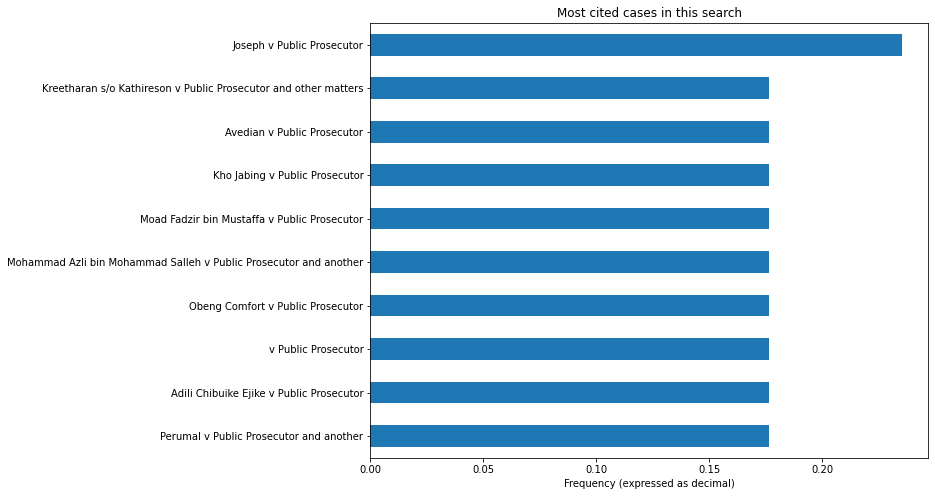

In [111]:
test = search_statistics(input_string)

### 3.3 Search by Offence

### 3.4 Analysis - Weather with number of mosquitos

## Exporting Data

In [38]:
# train_df.to_csv("../data/train_df_model.csv", index = False)
# test_df.to_csv("../data/test_df_model.csv", index = False)

## References

[1] "Atmospheric Pressure," *Britannica The Editors of Encyclopedia*, May 27, 2020. [Online]. Available: [https://www.britannica.com/science/atmospheric-pressure](https://www.britannica.com/science/atmospheric-pressure) [Accessed: May. 1, 2021].  

[2] "Humidity Formulas," *Go Grean*, 2014. [Online]. Available: [http://www.reahvac.com/tools/humidity-formulas/](http://www.reahvac.com/tools/humidity-formulas/) [Accessed: May. 1, 2021].

[3] "House Mosquitoes," *Biogents USA*. [Online]. Available: [https://us.biogents.com/house-mosquitoes/](https://us.biogents.com/house-mosquitoes/) [Accessed: May. 6, 2021].
 
[4] "Rising temperatures could shift US West Nile virus transmission," *ScienceDaily*, September 15, 2020. [Online]. Available: [https://www.sciencedaily.com/releases/2020/09/200915105932.htm#:~:text=West%20Nile%20virus%20spreads%20most,published%20today%20in%20eLife%20shows.](https://www.sciencedaily.com/releases/2020/09/200915105932.htm#:~:text=West%20Nile%20virus%20spreads%20most,published%20today%20in%20eLife%20shows.) [Accessed: May. 6, 2021]